In [1]:
#!/usr/bin/env python3

import glob
import re
import nibabel as nib
import numpy as np
import os
import argparse
import h5py
from sklearn import linear_model
from scipy import stats,special
from subprocess import call
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import nibabel as nb
import nilearn
from nilearn import plotting, surface, datasets
import sys
import tqdm
setpath = '/home/msachs/music_emo_events/'
if setpath not in sys.path:
    sys.path.append(setpath)
from settings import *
import importlib
from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.funcalign import srm

removesubs = ['sub-musevent05','sub-musevent06','sub-musevent80']
subs = [elem for elem in subs if elem.split('/')[5] not in removesubs] #if you want the cut ones

print('Num subs',len(subs))
#print(volspace)
#print(nilearn.__version__)

acompcor = 'acompcor'
print(acompcor)

/home/msachs/.local/lib/python3.6/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Num subs 9
acompcor


## Select an ROI

In [31]:
parcelfiles = [atlaspath + elem for elem in os.listdir(atlaspath) if numparcel in elem and numnetwork in elem and '._' not in elem]
for hemi in parcelfiles:
    lab = nib.freesurfer.io.read_annot(hemi)
    
roiname =  b'17Networks_LH_SomMotB_Aud_1'
roiname = b'17Networks_LH_DefaultB_PFCv_4'
roi_short=roiname.decode("utf-8")[11:]
data = dd.io.load(parcelpath+roi_short+acompcor+'.h5')
data.keys()


dict_keys(['a1', 'a2', 'b1', 'b2', 'rhap', 'vall', 'hemi'])

## APPLY TO RUN1 and RUN2

In [32]:
for pi,piecename in enumerate(pieces[:-2]):
    piece = piecename.split('_')[1]
    
    #get subs who heard this piece 
    haystack = [re.split('/|_',elem)[4] for elem in data['rhap']['subl']]
    st = set([re.split('/|_',elem)[4] for elem in data[piece.lower()]['subl']])
    subindx = [i for i, e in enumerate(haystack) if e in st]
    nSubj = len(subindx)

    temp = data['rhap']['D'][subindx,:,:]
    #sanity checks
    #np.isnan(np.std(temp, axis=2)).sum()
    #(temp==0).sum()
    #(np.std(temp, axis=2)==0).sum()
    
    traindata = [temp[i,:,:] for i in range(temp.shape[0])]
    print(piece,temp.shape,len(traindata))

    # Create the SRM object
    features = 50  # How many features will you fit?
    n_iter = 20  # How many iterations of fitting will you perform
    model = srm.SRM(n_iter=n_iter, features=features)
    print('Fitting SRM, may take a minute ...')
    model.fit(traindata)
    print('SRM has been fit: Features X Time-points ', model.s_.shape)

    temp2 = data[piece.lower()]['D'] #need it in voxels x tr x subject
    test_data = [temp2[i,:,:] for i in range(temp2.shape[0])]
    print(piece,temp2.shape,temp2.dtype,len(test_data),nSubj)
    
    # Transform the test data into the shared space using the individual weight matrices
    print('Transforming',piece,'to shared space')
    shared_test = model.transform(test_data)

    # Zscore the transformed test data
    for subject in range(nSubj):
        shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

    # Do the reconstruction on all individual participants and organize it for ISC
    signal_srm = np.zeros((test_data[1].shape[1], test_data[0].shape[0], len(test_data)))
    for ppt in range(len(test_data)):
        signal_srm[:, :, ppt] = model.w_[ppt].dot(shared_test[ppt]).T
    corr_reconstructed = isc(signal_srm, summary_statistic='mean')
    corr_reconstructed = np.nan_to_num(corr_reconstructed)

    # Reorganize the SRM transformed data back into an appropriate space for ISC
#     shared_obj = np.zeros((shared_test[0].shape[0], shared_test[0].shape[1], len(shared_test)))
#     for ppt in range(len(shared_test)):
#         shared_obj[:, :, ppt] = shared_test[ppt]
    
#     corr_shared = isc(shared_obj, summary_statistic='mean')
#     corr_shared = np.nan_to_num(corr_shared)

    # Perform ISC on all participants, collapsing across participants (want in tr x voxel x subject)
    rawdata = np.transpose(temp2, (2, 1, 0))                       
    corr_raw = isc(rawdata, summary_statistic='mean')
    corr_raw = np.nan_to_num(corr_raw)  
    
    tstat = stats.ttest_ind(np.arctanh(corr_raw), np.arctanh(corr_reconstructed))
    print(corr_raw.shape,np.mean(corr_raw),np.mean(corr_reconstructed))
    print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)
#isc(signal_srm.mean(axis = 0), summary_statistic='mean') #bit higher yea 
#isc(roidata_smooth['sadsh'].mean(axis = 0), summary_statistic='mean')

A1 (5, 276, 452) 5
Fitting SRM, may take a minute ...
SRM has been fit: Features X Time-points  (50, 452)
A1 (5, 276, 597) float64 5 5
Transforming A1 to shared space
(276,) 0.013827593592578092 0.01610033987710302
Independent samples t test between raw and SRM transformed data: -0.9688131941339898 p: 0.3330642340122273
A2 (4, 276, 452) 4
Fitting SRM, may take a minute ...
SRM has been fit: Features X Time-points  (50, 452)
A2 (4, 276, 597) float64 4 4
Transforming A2 to shared space
(276,) 0.0029411098861749706 0.004013848548509227
Independent samples t test between raw and SRM transformed data: -0.41658687679899453 p: 0.6771431361769233
B1 (4, 276, 452) 4
Fitting SRM, may take a minute ...
SRM has been fit: Features X Time-points  (50, 452)
B1 (4, 276, 597) float64 4 4
Transforming B1 to shared space
(276,) -0.007573127878085316 -0.0049284494213498
Independent samples t test between raw and SRM transformed data: -0.9454779198020781 p: 0.3448301105829664


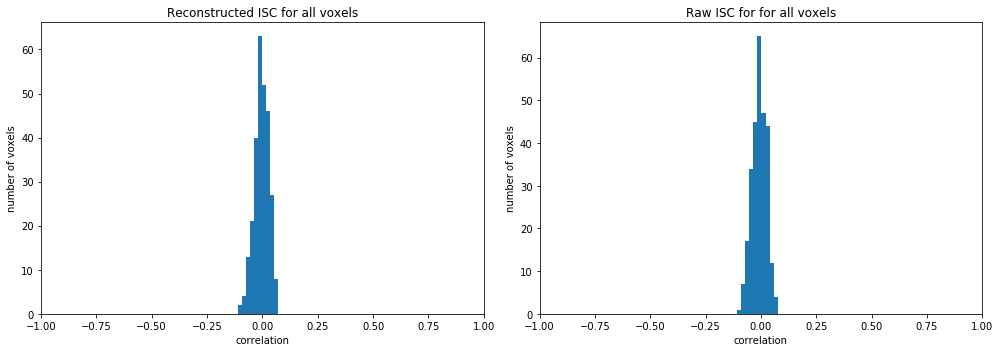

In [33]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.title('Reconstructed ISC for all voxels')
plt.hist(corr_reconstructed);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('Raw ISC for for all voxels')
plt.hist(corr_raw);
plt.xlabel('correlation')
plt.ylabel('number of voxels')
plt.xlim([-1, 1]);

plt.tight_layout()


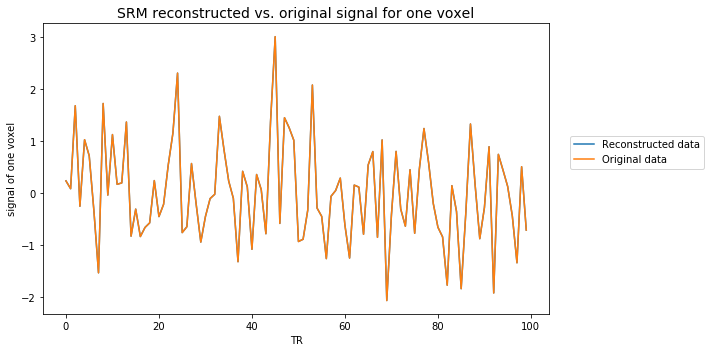

In [182]:
w0 = srm.w_[0]  # Weights for subject 1
signal_srm0 = w0.dot(shared_test[0])  # Reconstructed signal for subject 1
plt.figure(figsize=(10,5))
plt.title('SRM reconstructed vs. original signal for one voxel', fontsize=14)
plt.plot(signal_srm0[5,:100])
plt.plot(test_data[0][5,:100])
plt.xlabel('TR')
plt.ylabel('signal of one voxel')
plt.legend(('Reconstructed data', 'Original data'), loc=(1.04,0.5))
plt.tight_layout()

In [188]:
# temp = data['rhap']['D'] #need it in voxels x tr x subject
# print(temp.shape)
# #traindata = np.transpose(traindata, (1, 0, 2)                         
# traindata = [temp[i,:,:] for i in range(temp.shape[0])]
# print(len(traindata))

# # Create the SRM object
# features = 50  # How many features will you fit?
# n_iter = 20  # How many iterations of fitting will you perform
# srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features)
# # Fit the SRM data

# print('Fitting SRM, may take a minute ...')
# srm.fit(traindata)
# #print('SRM has been fit and has shape')
# print('SRM: Features X Time-points ', srm.s_.shape)

(9, 335, 452)
9
Fitting SRM, may take a minute ...
SRM: Features X Time-points  (50, 452)
